In [1]:
import re
import pandas as pd
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import numpy as np
import statistics
from scipy import stats
from scipy.stats import norm
from scipy.stats import boxcox
from impyute.imputation.cs import mice
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# model packages
import sklearn.model_selection as ms
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, Lasso, ElasticNet, LinearRegression, Ridge, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold 
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn import linear_model
from xgboost import XGBRegressor
from mlxtend.regressor import StackingCVRegressor

%matplotlib inline

In [2]:
# data = pd.read_csv("DATA.csv", low_memory = False)
# data.issue_d = pd.to_datetime(data.issue_d)
# data.years = data.issue_d.dt.year
# grouped = data.groupby(data.years, axis = 0)
# data1 = grouped.apply(lambda x: x.sample(n=1000, replace=True))
# data1 = data1.reset_index(drop = True)
# data1.to_csv('data1.csv')

In [3]:
data1 = pd.read_csv('data1.csv',low_memory = False)
data1 = data1.drop(['Unnamed: 0'], axis = 1)
#data1.columns.values
#data1.describe()
data1.sample(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
487,155369,NaN,6000.0,6000.0,1202.97,36 months,12.80,201.59,D,D4,Junaid Hashim MD,2 years,OWN,12000.0,Not Verified,2007-11-01,Does not meet the credit policy. Status:Fully ...,n,https://lendingclub.com/browse/loanDetail.acti...,Hello I need to pay tuition for the next semes...,educational,University of Buffalo Tuition payment,142xx,NY,3.00,0.0,Jul-2006,655.0,659.0,1.0,0.0,0.0,3.0,0.0,884.0,55.2,4.0,f,0.0,0.0,7258.418932,1444.86,6000.0,1243.42,15.00,0.0,0.0,Dec-2010,96.49,Dec-2010,Jul-2015,659.0,655.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4174,674034,NaN,13000.0,13000.0,13000.00,36 months,14.54,447.73,D,D1,Mount Sinai Hospital,5 years,OWN,47000.0,Not Verified,2011-03-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Never Again,110xx,NY,23.08,0.0,Nov-2000,675.0,679.0,1.0,32.0,NaN,13.0,0.0,18325.0,53.8,30.0,f,0.0,0.0,16156.788803,16156.79,13000.0,3134.40,22.39,0.0,0.0,May-2014,484.13,NaN,Mar-2019,644.0,640.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,N

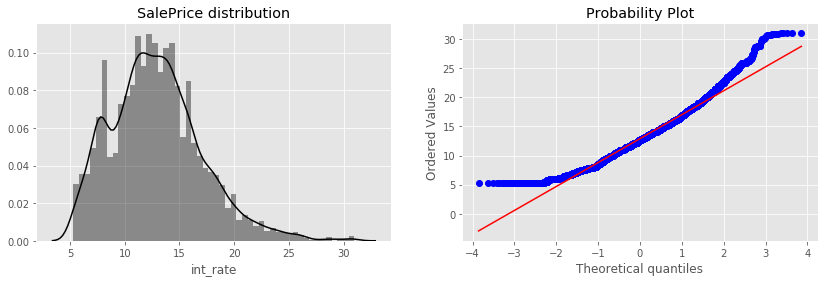

Skewness: 0.651340
Skewness: 0.735689


In [4]:
y = data1.int_rate
## Normality & linearity
fig, (ax1, res) = plt.subplots(1, 2, figsize=(14, 4))
sns.distplot(y, color = 'black', ax = ax1)
ax1.set_title('SalePrice distribution')
res = stats.probplot(y, plot=plt)
plt.show()
## Skewness, Kurtosis 
y_skew, y_kurt = y.skew(), y.kurt()
print('Skewness: %f' % y_skew)
print('Skewness: %f' % y_kurt)

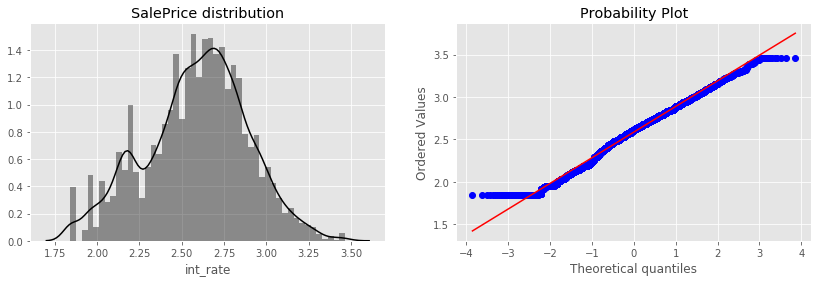

Skewness: -0.196887
Skewness: -0.233565


In [5]:
y = np.log1p(y) 
fig, (ax1, res) = plt.subplots(1, 2, figsize=(14, 4))
sns.distplot(y, color = 'black', ax = ax1)
ax1.set_title('SalePrice distribution')
res = stats.probplot(y, plot=plt)
plt.show()

y_skew, y_kurt = y.skew(), y.kurt()
print('Skewness: %f' % y_skew)
print('Skewness: %f' % y_kurt)

## If the skewness is between -0.5 and 0.5, the data are fairly symmetrical.

In [6]:
y.describe()

count    12000.000000
mean         2.587092
std          0.303174
min          1.842136
25%          2.396986
50%          2.615935
75%          2.791778
max          3.465423
Name: int_rate, dtype: float64

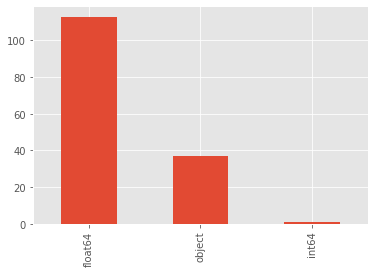

In [7]:
display(data1.dtypes.value_counts().plot(kind = 'bar'))

# missingness

In [8]:
# start the MICE training, mice inputation
# imputed_training=mice(data1)

## Checking missingness on Y variables
y_missing = data1.int_rate.isnull().sum()
print("Y misisngness: " + str(y_missing))

Y misisngness: 0


In [9]:
## missingness
missing = data1.isnull().sum().sort_values(ascending=False)
missing_percentage = data1.isnull().mean().sort_values(ascending=False)
missing_data = pd.concat([missing, missing_percentage], axis=1, keys=['Total', 'Percent'])
display(missing_data.head(3))

print('************************************')
## Checking number of over_70% missing columns
missing_data[missing_data.Percent > 0.7].count()

,Total,Percent
member_id,12000,1.000000
orig_projected_additional_accrued_interest,11977,0.998083
payment_plan_start_date,11968,0.997333


************************************


Total      56
Percent    56
dtype: int64

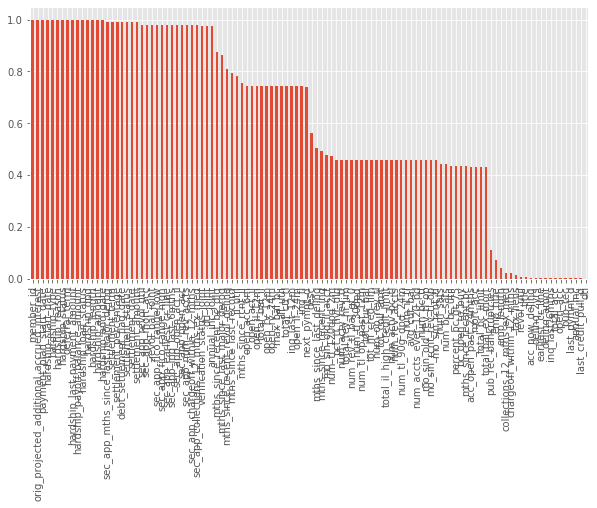

In [10]:
## Graph 
missing_percentage[missing_percentage > 0].plot(kind = 'bar', figsize=(10,5))

In [11]:
## Dropping columns with missingness over 50% 
data1.drop((missing_data[missing_data.Percent > 0.5]).index,axis = 1, inplace = True) 

In [12]:
## double checking columns 
data1.shape

(12000, 93)

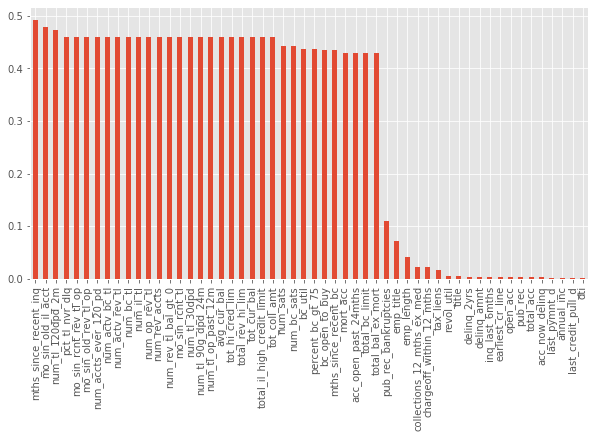

In [13]:
## After removing missing vaiables
after_removing_missing = data1.isnull().mean().sort_values(ascending=False)
after_removing_missing[after_removing_missing > 0].plot(kind = 'bar', figsize=(10,5))

In [14]:
def fillin_missing(features):
    features.emp_length = features.emp_length.str.extract('(\d+)')[0].fillna(0).astype(int)
    features.term = features.term.str.extract('(\d+)')[0].fillna(0).astype(int)
    
    ## filling in object type 
    objects = []
    for i in features.columns:
        if features[i].dtype == 'object':
            objects.append(i)
    features.update(features[objects].fillna('None'))
        
    # non-object 
    numeric = []
    for i in features.columns:
        if features[i].dtype != "object":
            numeric.append(i)
    features.update(features[numeric].fillna(0))    
    return features

data1 = fillin_missing(data1)

In [15]:
fillin_missing = data1.isnull().mean()
fillin_missing[0:5]

id                 0.0
loan_amnt          0.0
funded_amnt        0.0
funded_amnt_inv    0.0
term               0.0
dtype: float64

# Correlation

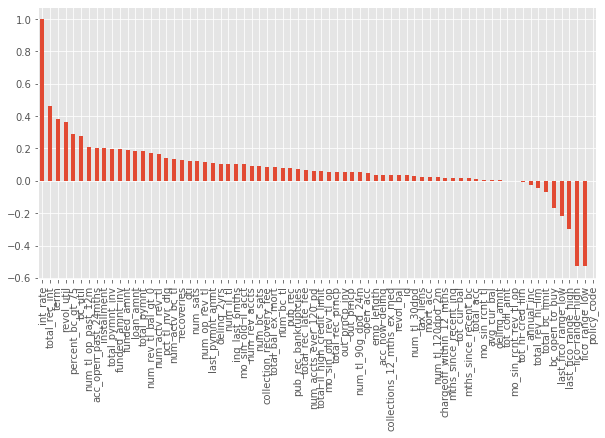

In [16]:
## correlation
num_type = data1.select_dtypes(exclude = 'object')
num_type_corr = num_type.corr(method = 'pearson') 
num_type_corr.int_rate.sort_values(ascending = False).plot(kind = 'bar', figsize=(10,5))

## heatmap
#f, ax = plt.subplots(figsize=(30, 20)
# sns.heatmap(num_type_corr, 
#             xticklabels=num_type_corr.columns,
#             yticklabels=num_type_corr.columns,
#             cmap='RdBu_r',
#             annot=True)

In [17]:
## checking multicollinearity  

# def internal_corr(cols):
#     for col in cols:
#         print(num_type.corr()[col].sort_values(ascending = False).head(5))
# internal_corr(num_type.columns)

In [18]:
data1.drop(['int_rate'], axis = 1, inplace = True)     ## dropping y

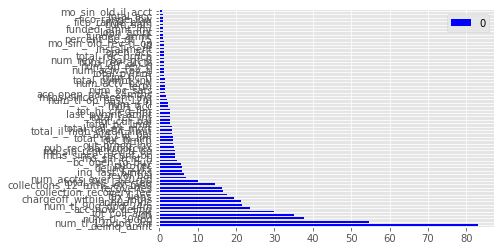

In [19]:
## If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.
numeric = []
for i in data1.columns:
    if data1[i].dtype != "object":
        numeric.append(i)
skews = data1[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)
skewh = skews[skews > 0.5] ##  According the definition of skewness, range of -0.5 and 0.5 is symmetric
skewh = pd.DataFrame(skewh)
skewh_index = skewh.index
#skewh
skewh.plot.barh(color = "blue")
plt.show()

C:\Users\Evinl\Anaconda3\lib\site-packages\scipy\stats\stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


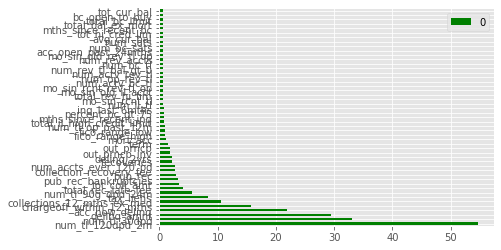

In [20]:
for i in skewh_index:
   data1[i] = boxcox1p(data1[i], boxcox_normmax(data1[i] + 1))
skews = data1[skewh_index].apply(lambda x: skew(x)).sort_values(ascending=False)
skewh = skews[skews > 0.5]
skewh = pd.DataFrame(skewh)
skewh.plot.barh(color = "green")
plt.show()

In [21]:
display(data1.shape)

(12000, 92)

In [22]:
train_dummies = pd.get_dummies(data1)
#train_dummies.dropna(inplace=True)

In [23]:
# lin = LinearRegression()
# lin.fit(train_dummies, y);
# fitted = lin.predict(train_dummies)
# res = y - fitted
# outlier = abs(res) > 20
# plt.plot(fitted, res, 'ko', alpha = 0.1)
# plt.plot(fitted[outlier], res[outlier], 'ro')
# plt.xlabel('Fitted Value')
# plt.ylabel('Residual');

## Model

In [24]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, train_dummies, y, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

In [25]:
alphas_r = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas_l = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
alphas_e = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
l1ratio_e = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [26]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_r, cv=kf))

lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas_l, random_state=42, cv=kf))

elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=alphas_e, cv=kf, l1_ratio=l1ratio_e)) 

gbr = GradientBoostingRegressor(n_estimators=3000, 
                                learning_rate=0.05, 
                                max_depth=4, max_features='sqrt', 
                                min_samples_leaf=15, min_samples_split=10, 
                                loss='huber', random_state =42) 

rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, rf),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [ ]:
score = rmse_cv(ridge)
print("ridge: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), )

score = rmse_cv(lasso)
print("lasso: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), )

score = rmse_cv(elasticnet)
print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), )

score = rmse_cv(gbr)
print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), )

score = rmse_cv(rf)
print("random forest: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), )

score = rmse_cv(xgboost)
print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), )

In [ ]:
print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(train_dummies), np.array(y))

print('lasso')
lasso_model_full_data = lasso.fit(train_dummies, y)

print('ridge')
ridge_model_full_data = ridge.fit(train_dummies, y)

print('elastic net')
elastic_model_full_data = elasticnet.fit(train_dummies, y)

print('gradient boosting')
gbr_model_full_data = gbr.fit(train_dummies, y)

print('random forest')
rf_model_full_data = rf.fit(train_dummies, y)

print('xgboost')
xgb_model_full_data = xgboost.fit(train_dummies, y)


In [ ]:
def blended_predictions(x):
    return ((0.1 * lasso_model_full_data.predict(x)) + \
            (0.1 * ridge_model_full_data.predict(x)) + \
            (0.1 * elastic_model_full_data.predict(x)) + \
            (0.2 * gbr_model_full_data.predict(x)) + \
            (0.05 * rf_model_full_data.predict(x)) + \
            (0.1 * xgb_model_full_data.predict(x)) + \
            (0.35 * stack_gen_model.predict(np.array(x))))

In [ ]:
blended_score = rmsle(y, blended_predictions(train_dummies))
print('RMSLE score on train data:')
print(blended_score)

In [ ]:
blended_score = rmsle(y, blended_predictions(train_dummies))

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(y, blended_predictions(train_dummiesn)))
rms

In [ ]:
# rr = Ridge(alpha=13)
# rr.fit(train_dummies, y)
# np.sqrt(-cross_val_score(rr, train_dummies, y, cv=5, scoring="neg_mean_squared_error")).mean()

In [ ]:
# er = ElasticNet(alpha=0.001, l1_ratio=0.58)
# er.fit(train_dummies, y)
# np.sqrt(-cross_val_score(er, train_dummies, y, cv=5, scoring="neg_mean_squared_error")).mean()